# Evolution in music through the years

This notebook contains all information about our data processing steps.  

*Due to problem with the cluster only the subset of the data set was analysed locally*  

These include data analysis, cleaning, processing, engineering and visualisation.  
For the intermediate milestone we will also provide an updated plan.

In [1]:
%matplotlib inline
# Provided library to access hdf5 files from MillionSong dataset
import getters as hdf5_getters

import sqlite3 as sq
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression

## Data Fetching 

In [2]:
local_path = 'C:/Users/M4X/Documents/Uni/EPFL/ADA/ADA/project/data'
#local_path = 'C:/Users\Max-Pc/Downloads/millionsongsubset_full/MillionSongSubset/data'

In [3]:
def get_all_interesting_data(basedir,ext='.h5') :
    datas = []
    iteration = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        for f in files:
            oneSongData = []
            h5 = hdf5_getters.open_h5_file_read(f)
            
            # Columns wich we want to analyse 
            oneSongData.append( hdf5_getters.get_artist_id(h5))
            oneSongData.append(hdf5_getters.get_artist_name(h5))
            oneSongData.append(hdf5_getters.get_year(h5))
            oneSongData.append(hdf5_getters.get_danceability(h5))
            oneSongData.append(hdf5_getters.get_duration(h5))
            oneSongData.append(hdf5_getters.get_song_hotttnesss(h5))
            oneSongData.append(hdf5_getters.get_title(h5))
            oneSongData.append(hdf5_getters.get_tempo(h5))
            oneSongData.append(hdf5_getters.get_time_signature(h5))
            oneSongData.append(hdf5_getters.get_time_signature_confidence(h5))
            oneSongData.append(hdf5_getters.get_artist_mbtags(h5))
            oneSongData.append(hdf5_getters.get_artist_terms(h5))
            oneSongData.append(hdf5_getters.get_artist_location(h5))
            oneSongData.append(hdf5_getters.get_artist_latitude(h5))
            oneSongData.append(hdf5_getters.get_artist_longitude(h5))
            
            h5.close()
            
            # Print progress
            iteration+=1
            if(iteration%1000== 0):
                print(iteration)
                
            datas.append(oneSongData)
    return datas

In [4]:
datas = get_all_interesting_data(local_path)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [5]:
df = pd.DataFrame(datas,columns=['ArtistID','ArtistName','SongYear','SongDanceability','Duration','SongHotness',\
                                 'SongTitle','SongTempo','SongTimeSignature','SongTimeSignatureConfidence','ArtistMbtags',\
                                 'ArtistTerms','ArtistLocation','ArtistLatitude','ArtistLongitude'])

## Data Analysis and Cleaing

Since we want to analyze music evolution over time, we cannot use Songs without specified year. They are then dropped.

In [6]:
print("Dropping {} rows.".format(df[df['SongYear'] == 0].shape[0]))
df = df[df['SongYear']>0]

Dropping 5320 rows.


In [7]:
df.columns

Index(['ArtistID', 'ArtistName', 'SongYear', 'SongDanceability', 'Duration',
       'SongHotness', 'SongTitle', 'SongTempo', 'SongTimeSignature',
       'SongTimeSignatureConfidence', 'ArtistMbtags', 'ArtistTerms',
       'ArtistLocation', 'ArtistLatitude', 'ArtistLongitude'],
      dtype='object')

In [8]:
df.head()

,ArtistID,ArtistName,SongYear,SongDanceability,Duration,SongHotness,SongTitle,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistMbtags,ArtistTerms,ArtistLocation,ArtistLatitude,ArtistLongitude
1,b'ARMJAGH1187FB546F3',b'The Box Tops',1969,0.0,148.03546,NaN,b'Soul Deep',121.274,4,0.384,[b'classic pop and rock'],"[b'blue-eyed soul', b'pop rock', b'blues-rock'...","b'Memphis, TN'",35.14968,-90.04892
3,b'AR7G5I41187FB4CE6C',b'Adam Ant',1982,0.0,233.40363,NaN,b'Something Girls',119.293,4,0.000,"[b'uk', b'british', b'english']","[b'pop rock', b'new wave', b'dance rock', b'ro...","b'London, England'",NaN,NaN
4,b'ARXR32B1187FB57099',b'Gob',2007,0.0,209.60608,0.604501,b'Face the Ashes',129.738,4,0.562,[],"[b'pop punk', b'ska punk', b'breakcore', b'alt...",b'',NaN,NaN
8,b'AR8ZCNI1187B9A069B',b'Planet P Project',1984,0.0,269.81832,0.265861,b'Pink World',86.643,4,0.487,[],"[b'new wave', b'progressive rock', b'space roc...",b'',NaN,NaN
14,b'ARIK43K1187B9AE54C',b'Lionel Richie',1986,0.0,307.38240,NaN,b'Tonight Will Be Alright',125.197,3,0.211,[b'soul and reggae'],"[b'quiet storm', b'soft rock', b'pop', b'urban...","b'Beverly Hills, CA'",NaN,NaN


In [9]:
df.isnull().sum()

ArtistID                          0
ArtistName                        0
SongYear                          0
SongDanceability                  0
Duration                          0
SongHotness                    1616
SongTitle                         0
SongTempo                         0
SongTimeSignature                 0
SongTimeSignatureConfidence       0
ArtistMbtags                      0
ArtistTerms                       0
ArtistLocation                    0
ArtistLatitude                 2855
ArtistLongitude                2855
dtype: int64

We notice, that 1616/4680 Songs do not have a defined Hotness.  
Furthermore, the Latitude and Longitude of the arists for 2855 Songs is not defined.  
For now we will keep the features and rows with NAN, and we will remove them if it would be neccessary to take the NANs into account.  
Let's have a deeper look at the different columns:

In [10]:
df.describe()

,SongYear,SongDanceability,Duration,SongHotness,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistLatitude,ArtistLongitude
count,4680.000000,4680.0,4680.000000,3064.000000,4680.000000,4680.000000,4680.000000,1825.000000,1825.000000
mean,1997.232051,0.0,238.781146,0.444377,125.163716,3.586111,0.510216,37.501760,-61.772744
std,11.686691,0.0,101.345438,0.222470,35.272251,1.240247,0.375063,16.273911,51.525675
min,1926.000000,0.0,1.044440,0.000000,0.000000,0.000000,0.000000,-41.280540,-155.434140
25%,1993.000000,0.0,181.152200,0.313562,98.698500,3.000000,0.089000,34.053490,-93.264930
50%,2001.000000,0.0,227.382400,0.473347,122.226500,4.000000,0.553000,40.102160,-79.385330
75%,2006.000000,0.0,278.406080,0.604554,146.572000,4.000000,0.868000,44.979030,-3.996670
max,2010.000000,0.0,1598.197100,1.000000,258.677000,7.000000,1.000000,69.651020,174.767140


By analysing the descriptive statistics of each columns we gained the following insights:

|         |        ArtistID       | ArtistName         |         SongYear        | SongDanceability |       Duration      |   SongHotness   | SongTitle |  SongTempo |    SongTimeSignature   |      SongTimeSignatureConfidence      |                 ArtistMbtags                |                      ArtistTerms                     | ArtistLocation |  ArtistLatitude  |  ArtistLongitude  |
|:-------:|:---------------------:|--------------------|:-----------------------:|:----------------:|:-------------------:|:---------------:|:---------:|:----------:|:----------------------:|:-------------------------------------:|:-------------------------------------------:|:----------------------------------------------------:|:--------------:|:----------------:|:-----------------:|
|  format |         string        |       string       |           int           |       float      |        float        |      float      |   string  |    float   |           int          |                 float                 |                    string                   |                        string                        |     string     |       float      |       float       |
|   type  |       categorial      |     categorial     |        continious       |    continious    |      continious     |    continious   |     -     | continious |         Ordinal        |               continious              |                                             |                                                      |                |    continious    |     continious    |
| comment | identifier for artist | name of the Artist | years from 1926 to 2010 |     always 0     | duration in seconds | between 0 and 1 |           |            | values between 0 and 7 | between 0 and 1, 1 is very confident  | comma seperated array with mbtags of artist | comma seperated array with echo nest terms of artist |   town, state  | default latitude | default longitude |

Now that we know a little bit more about the different features, let's have a deeper look at their distribution.

In [11]:
normalized_df = df.copy()

### Song Year

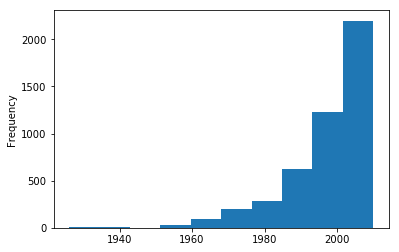

In [12]:
df.SongYear.plot(kind='hist')

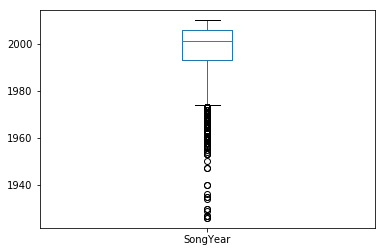

In [13]:
df.SongYear.plot.box()

The distribution of the year feature is negatively skewed.  
The available years span from 1926 to 2010.  
It makes sense to normalize the feature with scaling.
Normalize the year first

In [14]:
normalized_df.SongYearNorm = (df.SongYear-df.SongYear.min())/ \
                            (df.SongYear.max()-df.SongYear.min())
normalized_df.head()

,ArtistID,ArtistName,SongYear,SongDanceability,Duration,SongHotness,SongTitle,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistMbtags,ArtistTerms,ArtistLocation,ArtistLatitude,ArtistLongitude
1,b'ARMJAGH1187FB546F3',b'The Box Tops',0.511905,0.0,148.03546,NaN,b'Soul Deep',121.274,4,0.384,[b'classic pop and rock'],"[b'blue-eyed soul', b'pop rock', b'blues-rock'...","b'Memphis, TN'",35.14968,-90.04892
3,b'AR7G5I41187FB4CE6C',b'Adam Ant',0.666667,0.0,233.40363,NaN,b'Something Girls',119.293,4,0.000,"[b'uk', b'british', b'english']","[b'pop rock', b'new wave', b'dance rock', b'ro...","b'London, England'",NaN,NaN
4,b'ARXR32B1187FB57099',b'Gob',0.964286,0.0,209.60608,0.604501,b'Face the Ashes',129.738,4,0.562,[],"[b'pop punk', b'ska punk', b'breakcore', b'alt...",b'',NaN,NaN
8,b'AR8ZCNI1187B9A069B',b'Planet P Project',0.690476,0.0,269.81832,0.265861,b'Pink World',86.643,4,0.487,[],"[b'new wave', b'progressive rock', b'space roc...",b'',NaN,NaN
14,b'ARIK43K1187B9AE54C',b'Lionel Richie',0.714286,0.0,307.38240,NaN,b'Tonight Will Be Alright',125.197,3,0.211,[b'soul and reggae'],"[b'quiet storm', b'soft rock', b'pop', b'urban...","b'Beverly Hills, CA'",NaN,NaN


### Song Danceability

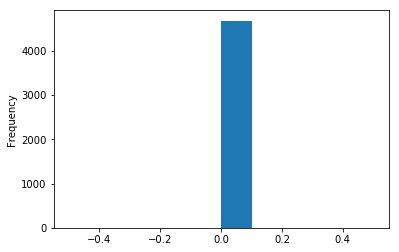

In [15]:
df.SongDanceability.plot(kind='hist')

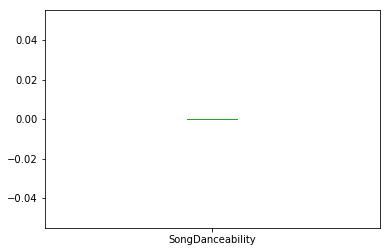

In [16]:
df.SongDanceability.plot.box()

All songs of our cleaned data frame has danceability `0`.  
Therefore we will drop this column.  

In [17]:
normalized_df.drop(labels=['SongDanceability'], axis=1, inplace=True)

### Duration

(35, 15)
(73, 15)


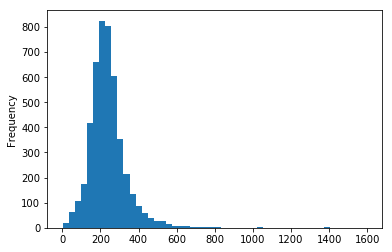

In [18]:
df.Duration.plot(kind='hist',bins=50)
print(df[df['Duration']>600].shape)
print(df[df['Duration']<60].shape)

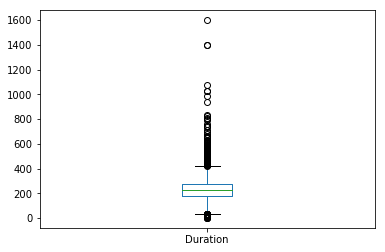

In [19]:
df.Duration.plot.box()

We can see in the histogram, that most of the songs are normal distributed.  
However, there are outliers with song durations over 10 minutes and under 60 seconds.   
In our normalized DataFrame we remove the outliers for the duration, since they might deviate too much from the average songs, which we want to analyse.

In [20]:
normalized_df = normalized_df[normalized_df['Duration']>60]
normalized_df = normalized_df[normalized_df['Duration']<600]

### Song Hotness

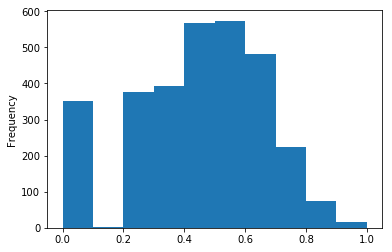

In [21]:
df.SongHotness.plot(kind='hist')

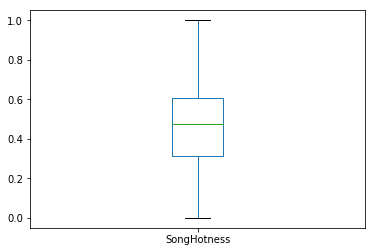

In [22]:
df.SongHotness.plot.box()

The distribution of the Hotness is not skewed.  
There are a few songs where the hotness is missing.  
When analysing hotness remove songs with hotness of zero. But for now we will keep the songs for other analysis tasks.

### Song Tempo 

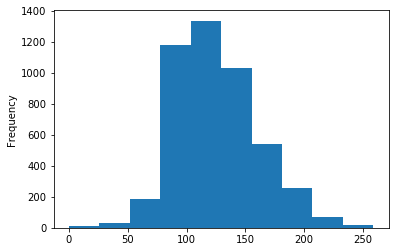

In [23]:
df.SongTempo.plot(kind='hist')

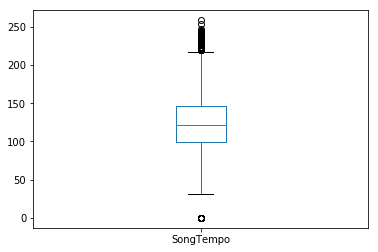

In [24]:
df.SongTempo.plot.box()

The distribution of the tempo is normal. There are some outliers with a very high or low tempo of more than 200 or less than 25.  
We will remove these outliers, since they might deviate from the average songs we want to analyse.

In [25]:
normalized_df = normalized_df[normalized_df['SongTempo']<220]
normalized_df = normalized_df[normalized_df['SongTempo']>25]

### Song Time Signature

The Song Time Signature describes the number of beats per bar.

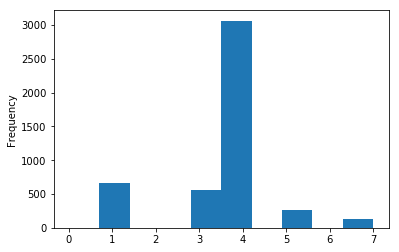

In [26]:
df.SongTimeSignature.plot(kind='hist')

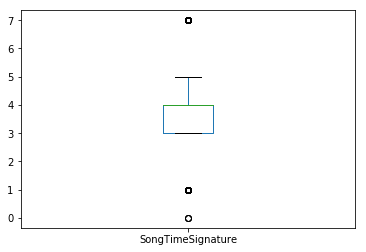

In [27]:
df.SongTimeSignature.plot.box()

The distribution of the Time signature also looks normally distributed, without many outliers.  
Therefore we will keep the feature as it is.

### Song Time Signature Confidence

The Song Time Signature Confidence describes the confidence in the Song Time Signature. It is 1 when the Song Time Signature is very accurate and 0 if is unknown.

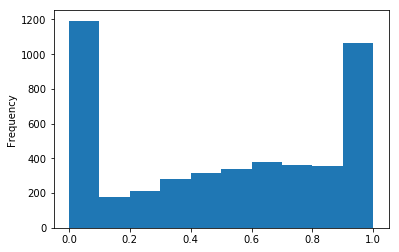

In [28]:
df.SongTimeSignatureConfidence.plot(kind='hist')

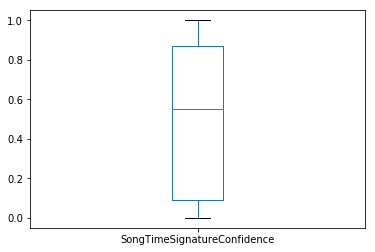

In [29]:
df.SongTimeSignatureConfidence.plot.box()

The majority of songs has either 0 or 1 as confidence. The other confidences are almost equally distributed.    
When analysing TimeSignature we will remove songs with low confidence, but keep the songs for now.

### Artist Location

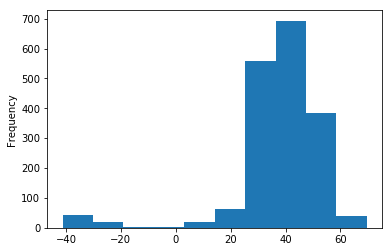

In [30]:
df.ArtistLatitude.plot(kind='hist')

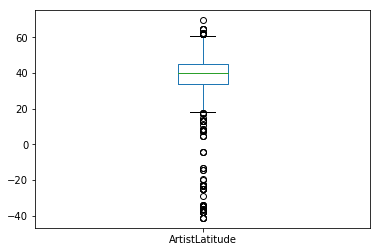

In [31]:
df.ArtistLatitude.plot.box()

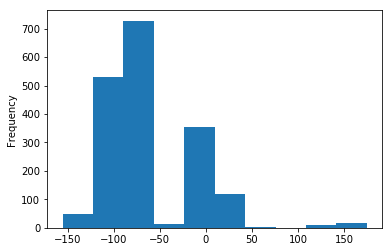

In [32]:
df.ArtistLongitude.plot(kind='hist')

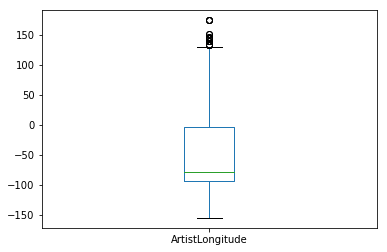

In [33]:
df.ArtistLongitude.plot.box()

We will keep the artist locations for now as they are, since we wanted to look at the correlation between different song types and artist locations.

## Data Correlation

In [34]:
normalized_df.corr()

,SongYear,SongDanceability,Duration,SongHotness,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistLatitude,ArtistLongitude
SongYear,1.000000,NaN,0.059714,0.072216,0.020238,0.122848,0.116367,-0.046133,0.017640
SongDanceability,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Duration,0.059714,NaN,1.000000,0.007171,-0.031175,0.103162,0.118071,0.082933,0.065677
SongHotness,0.072216,NaN,0.007171,1.000000,0.068544,0.036205,0.040898,0.059111,-0.058235
SongTempo,0.020238,NaN,-0.031175,0.068544,1.000000,0.054625,-0.146500,-0.004998,-0.017976
SongTimeSignature,0.122848,NaN,0.103162,0.036205,0.054625,1.000000,0.324779,0.027432,0.012819
SongTimeSignatureConfidence,0.116367,NaN,0.118071,0.040898,-0.146500,0.324779,1.000000,-0.000546,0.042804
ArtistLatitude,-0.046133,NaN,0.082933,0.059111,-0.004998,0.027432,-0.000546,1.000000,0.028890
ArtistLongitude,0.017640,NaN,0.065677,-0.058235,-0.017976,0.012819,0.042804,0.028890,1.000000


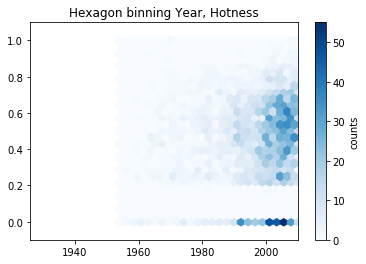

In [35]:
x = normalized_df.SongYear
y = normalized_df.SongHotness
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=25, cmap='Blues')
ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
ax.set_title("Hexagon binning Year, Hotness")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

TODO other plots, improve coloring with color bins

## Feature Engineering

TODO Handle genre arrays

TODO Genre Mapping + stats for different genres

## Updated Plan

### Gained Knowledge

TODO Reflect new knowledge, does data suits needs

### Methods for the future

** Use cluster and full data set, redo analysis **  

The data set contains already collected data so that a natural experiment is not possible.  
Propensity scores are hard to apply to time series. Therefore, we will use sensivity analysis to prove our results.  
  
TODO explain sensivity analysis

* Which features did change (e.g. bpm, beats)?
   * Calculate features aggregated by year, plot time series (with error bars)
   * Can we see a major change of one features over the years?
   * State results with sensivity analysis model
  
  
* How did genres change (e.g. popularity, features of specific genres, higher variance)?
    * Create data frame for each genre with songs of genre
    * Plot number of songs per year
    * Redo question one for features
    * Plot chart which shows span of features per year
    * Look at subgenres?
    * State results with sensivity analysis model
  
  
* How did the distribution of music change (e.g. change of number of genres, variance of features)?
    * Plot chart that shows the numer of features per year
    * Plot chart which shows genre distribution (number of songs per genre) over time
    * State results with sensivity analysis model
  
  
* Train classifier for genre on recent songs
    * Apply it to old songs
    * Evaluate the results
  

Ignore those since we lost one team member?
* Which songs from the past are still trending (why)?
* How did song titles (artist names) change over time?
* Where did (which) songs get released at which time (do dependencies exist between similar Songs)?
  
  
Other interesting analysis:
* Run unsupervised clustering
    * compare clusters to genres
* Compare song and artist name with codec (TODO explain)


It is hard to finally decide which methods will or will not work out, since we only had access to 1/1000 of the dataset.  
Therefore we might drop or add analysis for milestone 3.